In [1]:
import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 300)

In [2]:
f_vcf = "/scratch/sbanerj/trans-eqtl/input/gtex/genotype/all_samples/GTEx_v6_imput_info04_HWEp1E6_PASS_dbSNP135_maf1_noindels_noambig_chr5.vcf.gz"

In [4]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

def read_vcf(filename, startsnp, endsnp):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    dsindx = linesplit[8].split(':').index("DS")
                    ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                    gtindx = linesplit[8].split(':').index("GT")
                    for i, x in enumerate(ds):
                        if x == ".":
                            gt = linesplit[9+i].split(':')[gtindx]
                            if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                ds[i] = float(int(gt[0]) + int(gt[2]))

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1

    return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtcent

In [5]:
gtfull, snp_info, gt_donors = read_vcf(f_vcf, 0, 3)
newdosage = list()
for i, snp in enumerate(snp_info):
    bins = [0.66, 1.33]
    intdosage = np.digitize(gtfull[i], bins)
    newdosage.append(intdosage)
#gtint = np.array(newdosage)
gtint = np.array(gtfull)

In [202]:
ngene = 15000
nsample = 350
gx_rand = np.random.normal(0, 1, size = nsample * ngene).reshape((nsample, ngene))
gx_donors = random.sample(gt_donors, nsample)

In [203]:
from sklearn.decomposition import PCA
nComp = 5
pca = PCA()
pca.fit(gx_rand.T)
gx_rand_pca = np.dot(pca.transform(gx_rand.T)[:, nComp:], pca.components_[nComp:,:]).T

In [204]:
gx_rand_nomask = normalize_expr(gx_rand.T) / np.sqrt(nsample)
gx_rand_pca_nomask = normalize_expr(gx_rand_pca.T) / np.sqrt(nsample)

In [205]:
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
gx_rand_norm = gx_rand_nomask[:, exprmask]
gx_rand_pca_norm = gx_rand_pca_nomask[:, exprmask]

gt = normalize_and_center_dosage(gtint[:, vcfmask], snp_info)
sigmax2 = np.var(gt, axis = 1)
print(sigmax2)

[0.38307848 0.40573308 0.40764944]


In [209]:
def check_ukT_x(GX, GXPCA, GT, ax1, ax2, ax3, label1, label2):
    sigmabeta2 = 0.1 * 0.1
    niter = 1000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    Ut, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    U = Ut.T
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    S2fact = S2 / S2mod
    K = S2.shape[0]
    #K = 50
    
    Ytpca = GXPCA.T
    Utpca, Spca, Vtpca = np.linalg.svd(Ytpca, full_matrices=False)
    Upca = Utpca.T
    S2pca = np.square(Spca)
    S2modpca = S2pca + sigmax2 / sigmabeta2
    S2factpca = S2pca / S2modpca
   
    UTXiter = np.zeros(niter * K)
    UTXiterPCA = np.zeros(niter * K)
    Qiter = np.zeros(niter)
    QiterPCA = np.zeros(niter)
       
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        for j in range(K):
            ## Random
            utx = np.dot(U[j, :], permgt)
            Qiter[i] += np.square(utx) * S2fact[j]
            UTXiter[i * K + j] = utx
            
            utxpca = np.dot(Upca[j, :], permgt)
            QiterPCA[i] += np.square(utxpca) * S2factpca[j]
            UTXiterPCA[i * K + j] = utxpca
            
    ax1.hist(UTXiter, bins = 50, density = True, label = label1, alpha = 0.5)
    ax2.hist(UTXiter, bins = 50, density = True, label = label2, alpha = 0.5)
    x = np.linspace(-3, 3, 100)
    rv = stats.norm(loc = 0, scale = np.sqrt(sigmax2))
    ax1.plot(x, rv.pdf(x), label = 'Normal dist.')
    ax2.plot(x, rv.pdf(x), label = 'Normal dist.')
    
    xmax = max(np.max(Qiter), np.max(QiterPCA))
    xmin = min(np.min(Qiter), np.min(QiterPCA))
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax3.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = 'Random')
    ax3.hist(QiterPCA, bins = bins, density = True, alpha = 0.3, label = 'PCA')
    
    return UTXiter, UTXiterPCA, U, Upca, Qiter, QiterPCA
#     ax.scatter(S2, UTX, alpha=0.1)
    
    
#     ax.hist(UTXiterSmallS, bins = 50, density = True, label = 'UTX')
#     print(np.mean(UTXiterSmallS))
#     x = np.linspace(-3., 3., 100)
#     uktx_std = np.sqrt(2 * (K - 1) / (K + 2))
#     rv = stats.norm(loc = 0, scale = uktx_std)
#     ax.plot(x, rv.pdf(x), label = 'analytical')
    
#     print("====== {:s} ======".format(label))
#     print("Qscore:", Qscore)
#     print("muQ:", muQ)
#     print("sigmaQ:", sigmaQ)
    
#     xmax = np.max(Qiter)
#     xmin = np.min(Qiter)
#     #xmax = muQ + 4.0 * sigmaQ
#     #xmin = muQ - 4.0 * sigmaQ
#     bins = np.linspace(xmin, xmax, 50)
#     xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
#     x = np.linspace(xbin[0], xbin[-1], 100)
#     ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
#     rv = stats.norm(loc = muQ, scale = sigmaQ)
#     ax.plot(x, rv.pdf(x), label = 'analytical')
    
#     ax.set_title(label)

====== Random ======
Effective rank: 349
Keff: 183.455
First 4 singular values: 56.85 56.4424 56.2929 56.0807
Sx2 / Sb2: 38.3078
Qscore: 183.368
muQ: 183.981
sigmaQ: 1.01015
====== Random + PCA ======
Effective rank: 345
Keff: 182.119
First 4 singular values: 56.9406 56.553 56.4496 56.421
Sx2 / Sb2: 38.3078
Qscore: 181.485
muQ: 182.64
sigmaQ: 1.9153


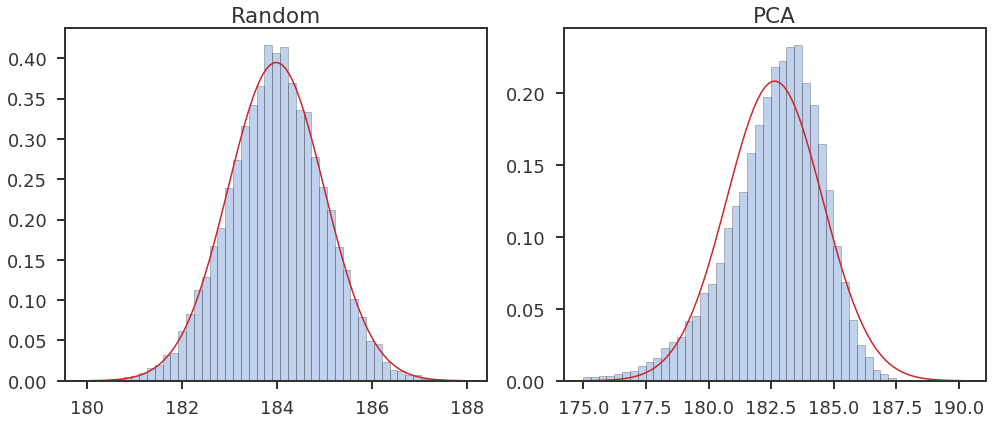

In [206]:
def shuffle_together(GX, GXPCA, GT, ax1, ax2, label1, label2):
    sigmabeta2 = 0.1 * 0.1
    niter = 20000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    mrank = len(np.where(S2 > 1)[0])

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
    Ytpca = GXPCA.T
    Upca, Spca, Vtpca = np.linalg.svd(Ytpca, full_matrices=False)
    S2pca = np.square(Spca)
    S2modpca = S2pca + sigmax2 / sigmabeta2
    mrankpca = len(np.where(S2pca > 1)[0])

    Wpca = np.dot(Upca, np.dot(np.diag(S2pca / S2modpca), Upca.T)) / sigmax2
    Qscorepca = np.sum(np.square(np.dot(Upca.T, GT)) * S2pca / S2modpca) / sigmax2
    pvalpca, muQpca, sigmaQpca = pvals_perm(GT.reshape(1, -1), Qscorepca, Wpca)
    
    Qiter = np.zeros(niter)
    Qiterpca = np.zeros(niter)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod) / sigmax2
        Qiterpca[i] = np.sum(np.square(np.dot(Upca.T, permgt)) * S2pca / S2modpca) / sigmax2
    
    print("====== Random ======")
    print("Effective rank: {:d}".format(mrank))
    print("Keff: {:g}".format(np.sum(S2 / S2mod)) )
    print("First 4 singular values: {:g} {:g} {:g} {:g}".format(S2[0], S2[1], S2[2], S2[3]))
    print("Sx2 / Sb2: {:g}".format(sigmax2 / sigmabeta2))
    print("Qscore: {:g}".format(Qscore))
    print("muQ: {:g}".format(muQ))
    print("sigmaQ: {:g}".format(sigmaQ))
    
    print("====== Random + PCA ======")
    print("Effective rank: {:d}".format(mrankpca))
    print("Keff: {:g}".format(np.sum(S2pca / S2modpca)) )
    print("First 4 singular values: {:g} {:g} {:g} {:g}".format(S2pca[0], S2pca[1], S2pca[2], S2pca[3]))
    print("Sx2 / Sb2: {:g}".format(sigmax2 / sigmabeta2))
    print("Qscore: {:g}".format(Qscorepca))
    print("muQ: {:g}".format(muQpca))
    print("sigmaQ: {:g}".format(sigmaQpca))

    
    #xmax = np.max(Qiter) + 1.5 * sigmaQ
    #xmin = np.min(Qiter) - 1.5 * sigmaQ
    xmax = muQ + 4.0 * sigmaQ
    xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax1.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax1.plot(x, rv.pdf(x), label = 'analytical')
    
    ax1.set_title(label1)
    
    xmax = muQpca + 4.0 * sigmaQpca
    xmin = muQpca - 4.0 * sigmaQpca
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax2.hist(Qiterpca, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
    rv = stats.norm(loc = muQpca, scale = sigmaQpca)
    ax2.plot(x, rv.pdf(x), label = 'analytical')
    
    ax2.set_title(label2)
    
    return Qiter, Qiterpca

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
Qiter, Qiter_pca = shuffle_together(gx_rand_norm, gx_rand_pca_norm, gt[0, :], ax1, ax2, 'Random', 'PCA')
plt.tight_layout()
plt.show()

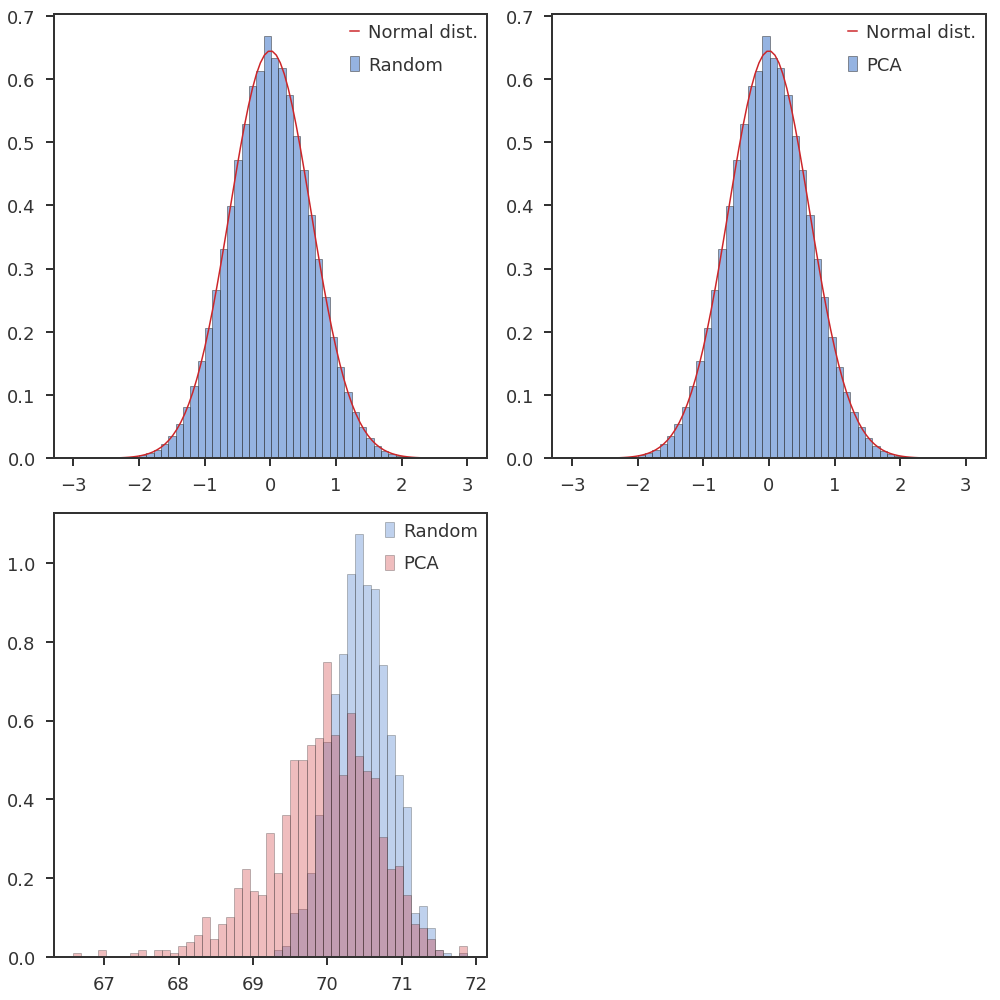

In [215]:
fig = plt.figure(figsize = (14, 14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
UTXiter, UTXiter_pca, U, Upca, Qiter, Qiter_pca = check_ukT_x(gx_rand_norm, gx_rand_pca_norm, gt[0, :], ax1, ax2, ax3, 'Random', 'PCA')
ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()
plt.show()

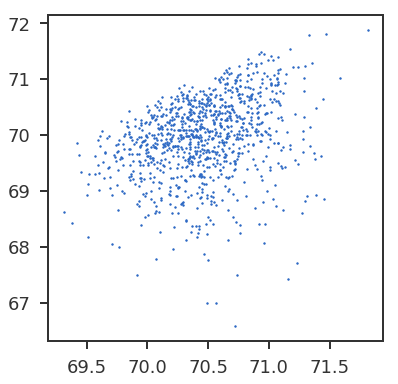

In [217]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(Qiter, Qiter_pca, s = 2, alpha = 1)
plt.show()

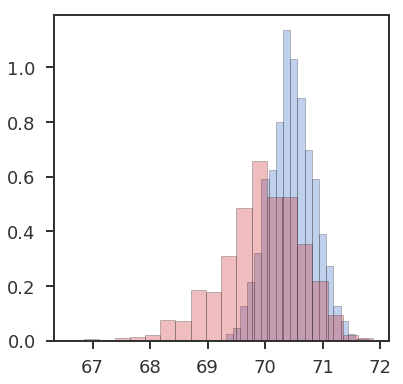

In [219]:
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.hist(Qiter, alpha = 0.3, density = True)
ax1.hist(Qiter_pca, alpha = 0.3, density = True)
plt.show()

In [213]:
Qiter.shape

(1000,)

In [117]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [ ]:
def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2, sigmabeta2 = 0.1 * 0.1):
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    K = S2.shape[0]
    mrank = len(np.where(S2 > 0.02)[0])

    print("====== {:s} ======".format(label))
    print("Effective rank: {:d}".format(mrank))
    S2mod = S2 + sigmax2[0] / sigmabeta2
    print( "Keff: {:g}".format(np.sum(S2 / S2mod)) )
    
    missing = K - mrank
#     ax1.plot(np.arange(missing, K), S2[:mrank], label = label)
#     ax2.plot(np.arange(missing, K), np.log10(S2 / S2mod)[:mrank], label = label)
    ax1.scatter(np.arange(S2.shape[0]), S2, label = label, s = 3., alpha = 1.)
    ax2.scatter(np.arange(S2.shape[0]), S2 / S2mod, label = label, s = 3., alpha = 1.)
    
    nsnps = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    for i in range(nsnps):
        S2mod = S2 + sigmax2[i] / sigmabeta2
        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) #/ sigmax2[i]
        Rscore[i] = np.sum(np.square(np.dot(U.T, GT[i,:])) * S2 / S2mod)
        pvals[i], muQ[i], sigmaQ[i] = pvals_perm(GT[i, :].reshape(1, -1), Rscore[i], W)
        
    print("Qscore:", Rscore)
    print("muQ:", muQ)
    print("sigmaQ:", sigmaQ)
    
    

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
compare_basic_props(gx_rand_norm, gt, ax1, ax2, 'Random', sigmax2)
compare_basic_props(gx_rand_pca_norm, gt, ax1, ax2, 'Random PCA', sigmax2)
ax1.legend()
ax2.legend()
#ax2.set_ylim(0.98, 0.995)
plt.tight_layout()
plt.show()

====== Random gene expression ======
Effective rank: 349
Keff: 188.383
First 4 singular values: 56.9494 56.6766 56.4225 56.3694
Sx2 / Sb2: 36.1819
Qscore: 188.026
muQ: 188.922
sigmaQ: 1.00752
====== After removing 20 PCs ======
Effective rank: 330
Keff: 182.576
First 4 singular values: 58.1254 58.0266 57.914 57.8271
Sx2 / Sb2: 36.1819
Qscore: 180.369
muQ: 183.099
sigmaQ: 3.50168


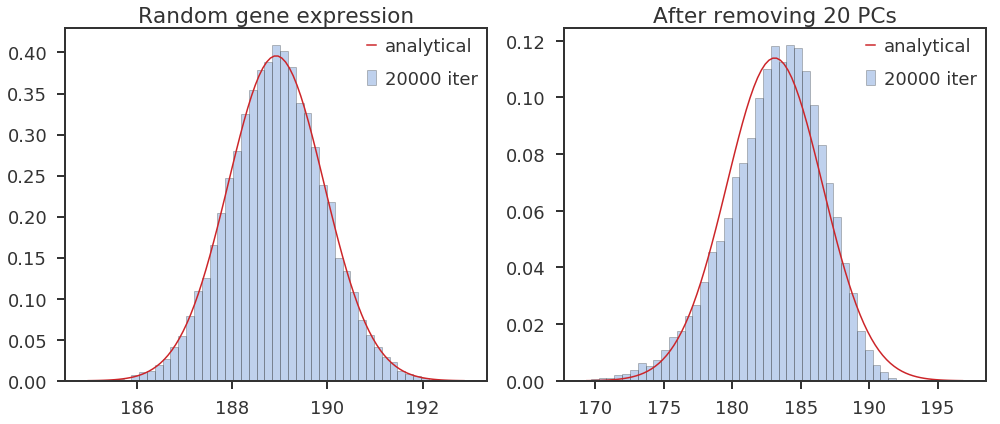

In [127]:
## Shuffle 1000 times, and get Qscore

def shuffle_and_plot(GX, GT, ax, label):
    sigmabeta2 = 0.1 * 0.1
    niter = 20000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    mrank = len(np.where(S2 > 1)[0])

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
    Qiter = np.zeros(niter)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod) / sigmax2
    
    print("====== {:s} ======".format(label))
    print("Effective rank: {:d}".format(mrank))
    print("Keff: {:g}".format(np.sum(S2 / S2mod)) )
    print("First 4 singular values: {:g} {:g} {:g} {:g}".format(S2[0], S2[1], S2[2], S2[3]))
    print("Sx2 / Sb2: {:g}".format(sigmax2 / sigmabeta2))
    print("Qscore: {:g}".format(Qscore))
    print("muQ: {:g}".format(muQ))
    print("sigmaQ: {:g}".format(sigmaQ))

    
    #xmax = np.max(Qiter) + 1.5 * sigmaQ
    #xmin = np.min(Qiter) - 1.5 * sigmaQ
    xmax = muQ + 4.0 * sigmaQ
    xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax.plot(x, rv.pdf(x), label = 'analytical')
    
    ax.set_title(label)
    
    return Qiter
    
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
Qiter_rand = shuffle_and_plot(gx_rand_norm, gt[0, :], ax1, "Random gene expression")
Qiter_rand_pca = shuffle_and_plot(gx_rand_pca_norm, gt[0, :], ax2, "After removing {:d} PCs".format(nComp))
ax1.legend()
ax2.legend()
plt.tight_layout()
#plt.savefig('../plots/PCA_correction_random_gene_expression.png')
plt.show()

In [ ]:
## Replace lowest singular values with slightly higher values

def shuffle_and_plot(GX, GT, ax, label):
    sigmabeta2 = 0.1 * 0.1
    niter = 20000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    mrank = len(np.where(S2 > 20)[0])

    ixSmall = S2 < 20
    S2rep = min(S2[~ixSmall])
    print("Lowest S2 values: ", S2[ixSmall])
    S2[ixSmall] = 5
    S2mod = S2 + sigmax2 / sigmabeta2

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
    Qiter = np.zeros(niter)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod) / sigmax2
    
    print("====== {:s} ======".format(label))
    print("Effective rank: {:d}".format(mrank))
    print("Keff: {:g}".format(np.sum(S2 / S2mod)) )
    print("First 4 singular values: {:g} {:g} {:g} {:g}".format(S2[0], S2[1], S2[2], S2[3]))
    print("Sx2 / Sb2: {:g}".format(sigmax2 / sigmabeta2))
    print("Qscore: {:g}".format(Qscore))
    print("muQ: {:g}".format(muQ))
    print("sigmaQ: {:g}".format(sigmaQ))

    
    #xmax = np.max(Qiter) + 1.5 * sigmaQ
    #xmin = np.min(Qiter) - 1.5 * sigmaQ
    xmax = muQ + 4.0 * sigmaQ
    xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax.plot(x, rv.pdf(x), label = 'analytical')
    
    ax.set_title(label)
    
    return Qiter
    
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
Qiter_rand = shuffle_and_plot(gx_rand_norm, gt[0, :], ax1, "Random gene expression")
Qiter_rand_pca = shuffle_and_plot(gx_rand_pca_norm, gt[0, :], ax2, "After removing {:d} PCs".format(nComp))
ax1.legend()
ax2.legend()
plt.tight_layout()
#plt.savefig('../plots/PCA_correction_random_gene_expression.png')
plt.show()

In [ ]:
def quantile_transform(Y):
    from sklearn.preprocessing import normalize
    from sklearn.preprocessing import QuantileTransformer
    Y_quant = QuantileTransformer(output_distribution='normal').fit_transform(Y.T).T
    return Y_quant

In [ ]:
## Explicit calculation of Qscore and p-values


def shuffle_and_plot(GX, GT, ax, label):
    sigmabeta2 = 0.05 * 0.05
    niter = 1000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    #U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    #S2 = np.square(S)
    #S2mod = S2 + sigmax2 / sigmabeta2

    #W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T))
    #Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod)
    
    Winner = np.linalg.inv(np.dot(Yt.T, Yt) + np.diag(np.repeat(sigmax2 / sigmabeta2, Yt.shape[1])))
    W = np.dot(Yt, np.dot(Winner, Yt.T)) / sigmax2
    Qscore = np.dot(GT.T, np.dot(W, GT))
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
    Qiter = np.zeros(niter)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        Qiter[i] = np.dot(permgt.T, np.dot(W, permgt))
        #Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod)
    
    print("====== {:s} ======".format(label))
    print("Qscore:", Qscore)
    print("muQ:", muQ)
    print("sigmaQ:", sigmaQ)
    
    #xmax = np.max(Qiter) + 1.5 * sigmaQ
    #xmin = np.min(Qiter) - 1.5 * sigmaQ
    xmax = muQ + 4.0 * sigmaQ
    xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax.plot(x, rv.pdf(x), label = 'analytical')
    
    ax.set_title(label)
    
    return Qiter
    
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
Qiter_rand = shuffle_and_plot(gx_rand_norm, gt[0, :], ax1, "Random gene expression")
Qiter_rand_pca = shuffle_and_plot(gx_rand_pca_norm, gt[0, :], ax2, "After removing 5 PCs")
ax1.legend()
ax2.legend()
plt.tight_layout()
#plt.savefig('../plots/PCA_correction_random_gene_expression.png')
plt.show()

In [ ]:
## Decouple singular values from eigenvectors, using S2 / S2mod = 1

def check_ukT_x(GX, GT, ax, label):
    sigmabeta2 = 0.05 * 0.05
    niter = 100
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    Ut, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    U = Vt.T
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    K = S2.shape[0]
    
    
#     UTXiterLargeS = np.arange([])
    ixSmall = S2<10
    nix = np.sum(ixSmall)
    UTXiterSmallS = np.zeros(niter * nix)
    sumUTX = np.zeros(niter)
       
    
    UTXiter = np.zeros(niter * K)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        UTX = np.dot(U.T, permgt)
        UTXiter[i * K : (i+1) * K] = UTX
        UTXiterSmallS[i * nix : (i + 1) * nix] = UTX[ixSmall]
        sumUTX[i] = np.sum(np.square(UTX))
    
#     ax.hist(sumUTX)
    print(sumUTX)
    print(np.sqrt(K))
#     ax.scatter(S2, UTX, alpha=0.1)
    
    
#     ax.hist(UTXiterSmallS, bins = 50, density = True, label = 'UTX')
#     ax.hist(UTXiter, bins = 50, density = True, label = 'UTX')
#     print(np.mean(UTXiterSmallS))
#     x = np.linspace(-3., 3., 100)
#     uktx_std = np.sqrt(2 * (K - 1) / (K + 2))
#     rv = stats.norm(loc = 0, scale = uktx_std)
#     ax.plot(x, rv.pdf(x), label = 'analytical')
    
#     UTX = np.dot(U.T, GT)
#     print(UTX)
#     ax.scatter(S2, UTX)
#     Qiter = np.zeros(niter)
#     permgt = GT.copy()
#     for i in range(niter):
#         np.random.shuffle(permgt)
#         Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)))
    
#     print("====== {:s} ======".format(label))
#     print("Qscore:", Qscore)
#     print("muQ:", muQ)
#     print("sigmaQ:", sigmaQ)
    
#     xmax = np.max(Qiter)
#     xmin = np.min(Qiter)
#     #xmax = muQ + 4.0 * sigmaQ
#     #xmin = muQ - 4.0 * sigmaQ
#     bins = np.linspace(xmin, xmax, 50)
#     xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
#     x = np.linspace(xbin[0], xbin[-1], 100)
#     ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
#     rv = stats.norm(loc = muQ, scale = sigmaQ)
#     ax.plot(x, rv.pdf(x), label = 'analytical')
    
#     ax.set_title(label)
    
#     return Qiter
    
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
Qiter_rand = check_ukT_x(gx_rand_norm, gt[0, :], ax1, "Random gene expression")
Qiter_rand_pca = check_ukT_x(gx_rand_pca_norm, gt[0, :], ax2, "After removing 5 PCs")
ax1.legend()
ax2.legend()
plt.tight_layout()
#plt.savefig('../plots/PCA_correction_random_gene_expression.png')
plt.show()

In [ ]:
def svd_Qscore(GX, GT, sigmax, sigmabeta):
    Yt = GX.T
    sigmax2 = sigmax * sigmax
    sigmabeta2 = sigmabeta * sigmabeta
    
    Ut, S, V = np.linalg.svd(Yt, full_matrices=False)
    U = Ut.T
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    
    W = np.zeros_like(U)
    Qscore = 0
    for i in range(U.shape[0]):
        W += np.outer(U[i, :], U[i, :]) * S2[i] / S2mod[i]
        Qscore += np.square(np.dot(U[i,:], GT)) * S2[i] / S2mod[i]
    W = W / sigmax2
    Qscore = Qscore / sigmax2
    
    return W, Qscore

def implemented_Qscore(GX, GT, sigmax, sigmabeta):
    Yt = GX.T
    sigmax2 = sigmax * sigmax
    sigmabeta2 = sigmabeta * sigmabeta
    
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod) / sigmax2
#     pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
    return W, Qscore

def explicit_Qscore(GX, GT, sigmax, sigmabeta):
    Yt = GX.T
    sigmax2 = sigmax * sigmax
    sigmabeta2 = sigmabeta * sigmabeta
    
    Winner = np.linalg.inv(np.dot(Yt.T, Yt) + np.diag(np.repeat(sigmax2 / sigmabeta2, Yt.shape[1])))
    W = np.dot(Yt, np.dot(Winner, Yt.T)) / sigmax2
    Qscore = np.dot(GT.T, np.dot(W, GT))
    
    return W, Qscore

In [ ]:
sigmax = np.std(gt[0, :])
sigmabeta = 0.05
W_svd, Qscore_svd = svd_Qscore(gx_rand_pca_norm, gt[0, :], sigmax, sigmabeta)
print("Qscore from SVD: {:f}".format(Qscore_svd))

In [ ]:
W_explicit, Qscore_explicit = explicit_Qscore(gx_rand_pca_norm, gt[0, :], sigmax, sigmabeta)
print("Qscore from explicit calculation: {:f}".format(Qscore_explicit))

In [ ]:
W_implemented, Qscore_implemented = implemented_Qscore(gx_rand_pca_norm, gt[0, :], sigmax, sigmabeta)
print("Qscore from implementation: {:f}".format(Qscore_implemented))

In [ ]:
W_svd

In [ ]:
W_explicit

In [ ]:
W_implemented

In [ ]:
# Check if centering is correct

gx_rand_cent = gx_rand - np.mean(gx_rand, axis = 0)
np.allclose(gx_rand_cent[:, 0], gx_rand[:, 0] - np.sum(gx_rand[:, 0]) / gx_rand.shape[0])

In [ ]:
np.sqrt(np.sum(np.square(gx_rand_cent[0, :])) / gx_rand_cent.shape[1])

In [ ]:
Y = gx_rand_nomask
YYT = np.dot(Y, Y.T)
YTY = np.dot(Y.T, Y)

In [ ]:
np.diag(YYT)

In [ ]:
np.diag(YTY)

In [ ]:
# Check if variance is correct

gx_rand_scaled = gx_rand_cen